**Ομάδα 23**

Νοταράς Ευάγγελος\
10084\
enotaras@ece.auth.gr\
\
Καλλιμάνης Ιωάννης\
10007\
ikallima@ece.auth.gr

In [ ]:
from google.colab import files

# Upload the dataset file
uploaded = files.upload()

In [ ]:
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from datetime import datetime

# Decision Boundaries Plotter Function

In [ ]:
def decision_plotter(model, X, X_test, y_test, y_pred, X_sv=None, sv_labels=None):
    h = 0.05  # Step size in the mesh
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.column_stack((xx.ravel(), yy.ravel())))  #predict the class labels for each point
    Z = Z.reshape(xx.shape)
    if X_sv is None:
      plt.figure()
    else:
      plt.figure(figsize=(10, 8))
    plt.clf()
    colors = ['blue', 'green', 'red']
    custom_cmap = ListedColormap(colors)
    plt.contourf(xx, yy, Z, cmap=custom_cmap, levels=20, alpha=0.2)

    for i in range(3):
      misclassified_indices = np.where((y_test != y_pred) & (y_test == (i + 1)))[0]
      correctly_classified_indices = np.where((y_test == y_pred) & (y_test == (i + 1)))[0]


      plt.scatter(X_test.iloc[correctly_classified_indices, 0], X_test.iloc[correctly_classified_indices, 1],
                c=colors[i], marker='o', label=f'class {i + 1} Correctly Classified')
      plt.scatter(X_test.iloc[misclassified_indices, 0], X_test.iloc[misclassified_indices, 1],
                c=colors[i], marker='x', label=f'class {i + 1} missclassified')

    if X_sv is not None:
      plt.scatter(X_sv[sv_labels == 1].iloc[:, 0], X_sv[sv_labels == 1].iloc[:, 1], marker='^', color='blue', label='Support Vectors (Class 1)')
      plt.scatter(X_sv[sv_labels == 2].iloc[:, 0], X_sv[sv_labels == 2].iloc[:, 1], marker='^', color='green', label='Support Vectors (Class 2)')
      plt.scatter(X_sv[sv_labels == 3].iloc[:, 0], X_sv[sv_labels == 3].iloc[:, 1], marker='^', color='red', label='Support Vectors (Class 3)')


    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# Load Dataset

In [ ]:
file_path = 'dataset.csv'
df = pd.read_csv(file_path, header=None)
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

# A) Bayesian Classifier Implementation


In [ ]:
class BayesianClassifier:
    def __init__(self, mode='diff'):
        """
        Bayesian Classifier Implementation

        Parameters:
        - mode (str): Covariance matrix mode. 'shared' means a shared matrix for all classes,
                      'diff' means each class has its own covariance matrix.
        """
        self.apriori={}
        self.class_means = {}
        self.cov_matrix = {}
        self.classes = None
        self.mode = mode

    def fit(self, X, y):
        # Fit the Bayesian Classifier to the training data
        self.classes = np.unique(y)
        temp_class_cov_matrix = {}
        for c in self.classes:
            class_data = X[y == c]
            class_size = len(class_data)

            # Apriori probability for each class
            self.apriori[c] = class_size / len(X)

            class_mean = np.mean(class_data, axis=0)
            self.class_means[c] = class_mean

            temp_class_cov_matrix[c] = np.cov(class_data, rowvar=False, bias=True)

        # Covariance matrices based on the mode
        if(self.mode == 'shared'):
            self.cov_matrix = sum(self.apriori[i] * temp_class_cov_matrix[i] for i in self.apriori)
        elif(self.mode == 'diff'):
            self.cov_matrix=temp_class_cov_matrix

    def predict(self, X):
        predictions = []
        for x in X:
            likelihoods = []
            for c in self.classes:
                class_mean = self.class_means[c]
                if(self.mode == 'shared'):
                    likelihood = self.multivariate_normal_pdf(x, class_mean, self.cov_matrix)
                elif(self.mode == 'diff'):
                    likelihood = self.multivariate_normal_pdf(x, class_mean, self.cov_matrix[c])

                total_likelihood = likelihood * self.apriori[c]
                likelihoods.append(total_likelihood)

            # Choose the class with the highest likelihood as the predicted class
            predicted_class = self.classes[np.argmax(likelihoods)]
            predictions.append(predicted_class)
        return np.array(predictions)

    def multivariate_normal_pdf(self, x, mean, cov):
        # Calculate multivariate normal probability density function
        d = len(mean)
        exponent = np.exp(-0.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(cov)), (x - mean)))
        prefactor = 1 / ((2 * np.pi) ** (d / 2) * np.linalg.det(cov) ** 0.5)
        return prefactor * exponent

Bayesian Classifier with shared covariance matrix

Accuracy (Same Cov Matrix): 0.7785714285714286
Elapsed Time: 0.065 seconds


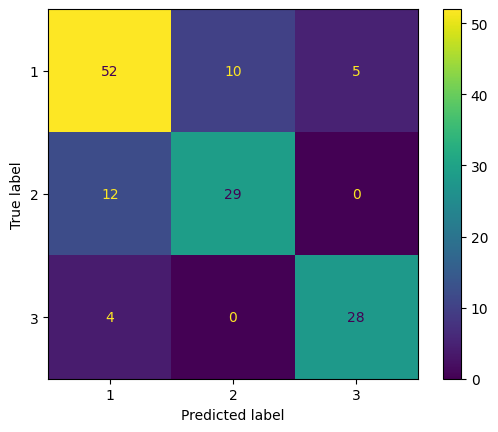

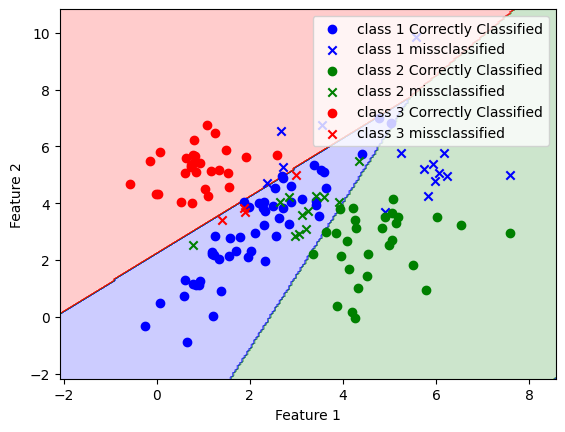

In [ ]:
t0=datetime.now()
gnb_same = BayesianClassifier(mode='shared')
gnb_same.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred_same = gnb_same.predict(X_test.to_numpy())

accuracy_same = accuracy_score(y_test, y_pred_same)
print("Accuracy (Same Cov Matrix):", accuracy_same)
print(f"Elapsed Time: {(datetime.now() - t0).total_seconds():.3f} seconds")

conf_matrix_same = confusion_matrix(y_test, y_pred_same)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_same, display_labels=[1,2,3])
disp.plot()
plt.show()

decision_plotter(gnb_same, X, X_test, y_test, y_pred_same)

Bayesian Classifier with different covariance matrix

Accuracy (Diff Cov Matrix): 0.85
Elapsed Time: 0.097 seconds


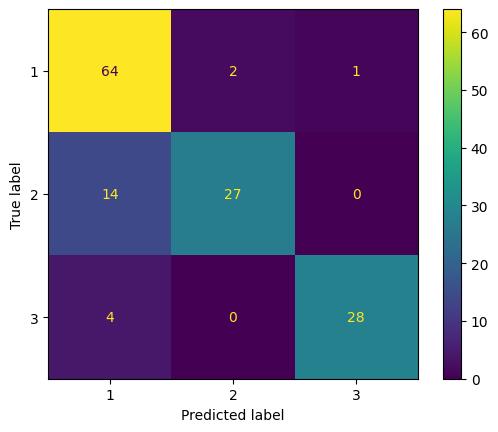

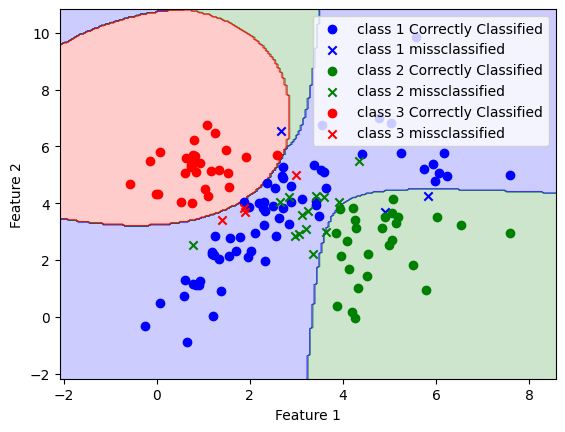

In [ ]:
t0=datetime.now()
gnb_diff = BayesianClassifier()
gnb_diff.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred_diff = gnb_diff.predict(X_test.to_numpy())

accuracy_diff = accuracy_score(y_test, y_pred_diff)
print("Accuracy (Diff Cov Matrix):", accuracy_diff)
print(f"Elapsed Time: {(datetime.now() - t0).total_seconds():.3f} seconds")

conf_matrix_diff = confusion_matrix(y_test, y_pred_diff)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_diff, display_labels=[1,2,3])
disp.plot()
plt.show()

decision_plotter(gnb_diff, X, X_test, y_test, y_pred_diff)

# B) KNN Classifier

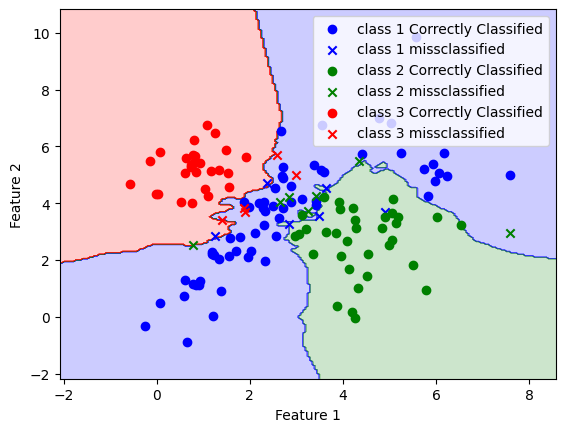

k= 5
Accuracy: 0.8571428571428571 	F1 socre: 0.85713529856387
Elapsed Time: 0.039 seconds


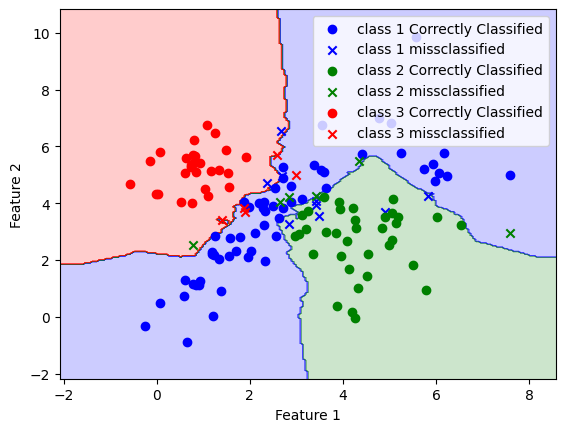

k= 6
Accuracy: 0.8714285714285714 	F1 socre: 0.8714936448552334
Elapsed Time: 0.027 seconds


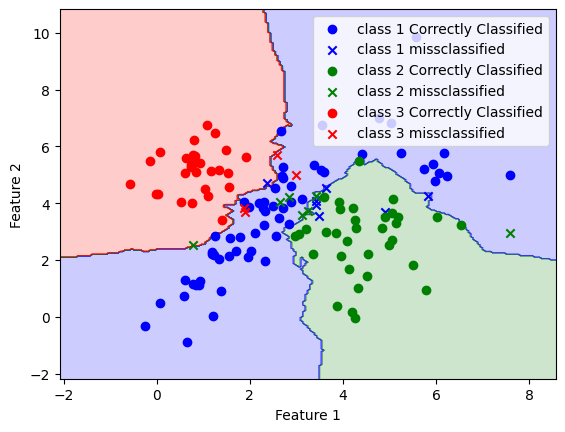

k= 7
Accuracy: 0.8785714285714286 	F1 socre: 0.8785714285714286
Elapsed Time: 0.029 seconds


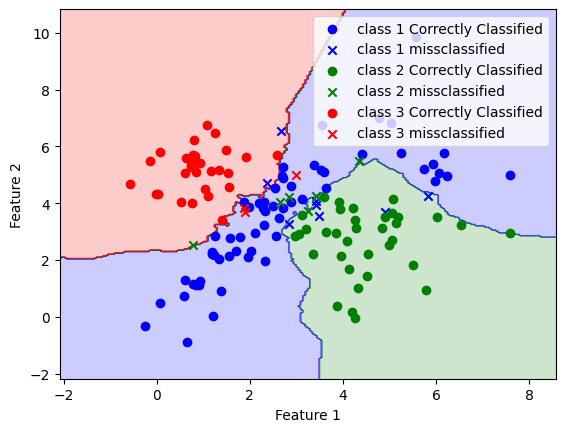

k= 8
Accuracy: 0.8785714285714286 	F1 socre: 0.8785714285714286
Elapsed Time: 0.036 seconds


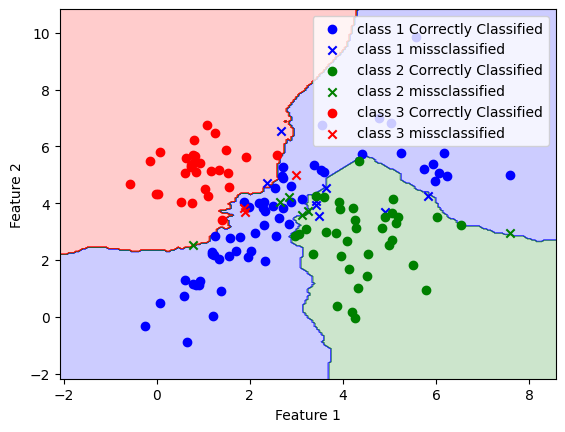

k= 9
Accuracy: 0.8857142857142857 	F1 socre: 0.8858733816107088
Elapsed Time: 0.040 seconds


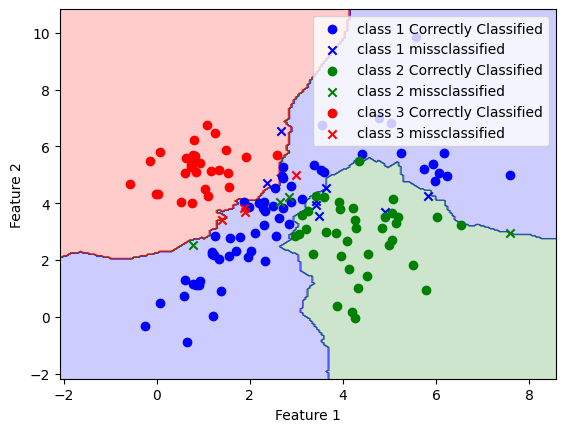

k= 10
Accuracy: 0.8857142857142857 	F1 socre: 0.8858633776091083
Elapsed Time: 0.061 seconds


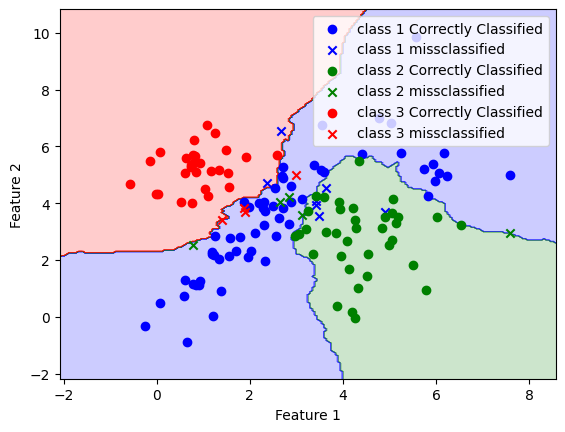

In [ ]:
for k in range(1, 11):
    t0=datetime.now()
    print("k=", k)
    model = KNeighborsClassifier(n_neighbors=k) # Sklearn 's function for KNN is used
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy, "\tF1 socre:", f1score)
    print(f"Elapsed Time: {(datetime.now() - t0).total_seconds():.3f} seconds")

    # Removing these comments will show the confusion matrices for each k
    #conf_matrix_same = confusion_matrix(y_test, y_pred)
    #disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_same, display_labels=[1, 2, 3])
    #disp.plot()
    #plt.title(f"Confusion Matrix (k={k})")
    #plt.show()

    decision_plotter(model, X, X_test, y_test, y_pred)

# C) Support Vector Machines

Tuning of the linear SVM

In [ ]:
param_grid = {'C': np.linspace(0, 10, 1000),
              'class_weight': ['balanced', None]}

grid = GridSearchCV(SVC(kernel='linear'), param_grid,  refit=True, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)
print('Best parameters after grid-search:')
print(grid.best_params_)
print('Best mean CV score: ', grid.best_score_)


 Implementation of the linear SVM

In [ ]:
svm_lin_model = SVC(kernel='linear', C=0.57, class_weight='balanced')
svm_lin_model.fit(X_train, y_train)
y_pred = svm_lin_model.predict(X_test)

support_vectors = svm_lin_model.support_vectors_
support_vector_labels = svm_lin_model.predict(support_vectors)
support_vectors = pd.DataFrame(data=support_vectors, columns=['Feature1', 'Feature2'])

accuracy = accuracy_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred, average='weighted')
print('Linear SVM')
print("Accuracy:", accuracy, "\tF1 socre:", f1score)

decision_plotter(svm_lin_model, X, X_test, y_test, y_pred, X_sv=support_vectors, sv_labels=support_vector_labels)

Tuning of the RBF SVM

In [ ]:
C_values = np.linspace(0.01, 50, 1000)
gamma_values = ['auto', 'scale']
param_grid = dict(gamma=gamma_values, C=C_values)

grid = GridSearchCV(SVC(kernel='rbf'), param_grid,  refit=True, cv=10, verbose=2, return_train_score=True)
grid.fit(X_train, y_train)
print('Best parameters ater grid-search:')
print(grid.best_params_)
print('Best mean CV score: ', grid.best_score_)

Implementation of the RBF SVM

In [ ]:
svm_rbf_model = SVC(kernel='rbf', C=13.9, class_weight=None, gamma='scale')
svm_rbf_model.fit(X_train, y_train)
y_pred = svm_rbf_model.predict(X_test)

support_vectors = svm_rbf_model.support_vectors_
support_vector_labels = svm_rbf_model.predict(support_vectors)
support_vectors = pd.DataFrame(data=support_vectors, columns=['Feature1', 'Feature2'])

print('RBF SVM')
accuracy = accuracy_score(y_test, y_pred)
f1score=f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy, "\tF1 socre:", f1score)

decision_plotter(svm_rbf_model, X, X_test, y_test, y_pred,  X_sv=support_vectors, sv_labels=support_vector_labels)